In [1]:
import os, sys
from tqdm import trange

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation

from model import MLP

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

GPU available


In [2]:
bounds = [-3, 3]
X_vol = bounds[1] - bounds[0]
diff = 1
gain = 1
n_datapoints = 25
compl = 20

# freq = np.sqrt((2 / (X_vol * np.exp(0.5))) * compl)
freq = (2 / X_vol) * compl

In [3]:
## Generate data
function = lambda x: diff * np.sin(freq * x) + 1
# sigma = 1 / freq
# function = lambda x: 1 / (sigma * np.sqrt(2 * np.pi)) * np.exp(-(x**2) / (2 * sigma))

train_datasets = [
    fun_data(device, function, bounds=bounds, n_datapoints=n_datapoints),
]
val_dataset = [fun_data(device, function, bounds=bounds, n_datapoints=101)]

tracked_datasets = val_dataset + train_datasets

encoding = Direct()

In [4]:
## Instantiate model
model = MLP(
    encoding=encoding,
    input_size=1,
    output_size=1,
    hidden_dim=30,
    n_hid_layers=10,
    device=device,
    init_std=gain,
)

In [5]:
## Setup compiler

# Define hyperparameters
n_epochs = 3000
lr = 0.0002

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-4)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    ),
    "hidden_early": ActivationTracker(model, lambda inputs: model(inputs)[1][2]),
    "hidden_late": ActivationTracker(model, lambda inputs: model(inputs)[1][8]),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [6]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=100
)

Training: 100%|██████████| 3000/3000 [00:49<00:00, 60.53steps/s, train_loss=0.04680, val_loss=0.11214]


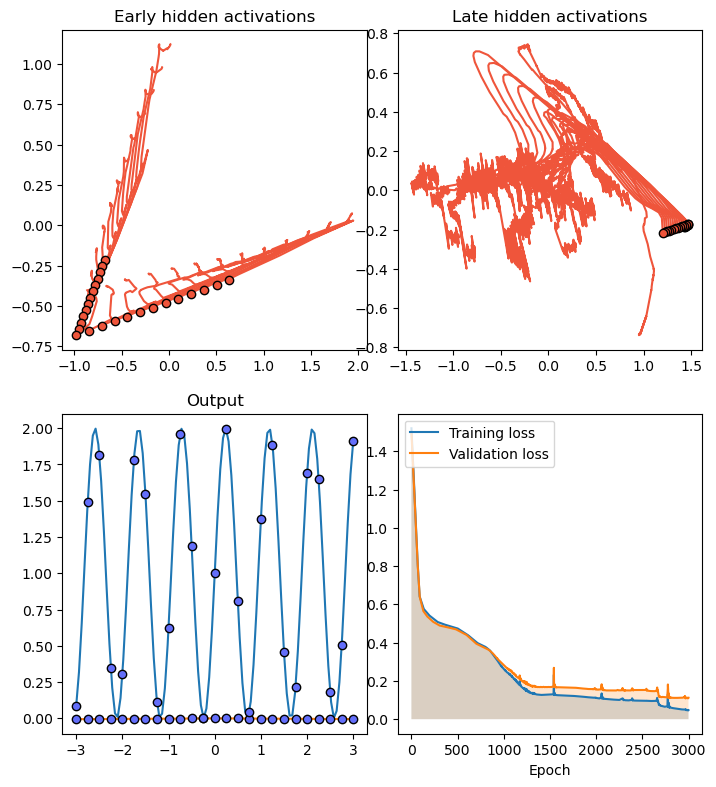

interactive(children=(SelectionSlider(description='Epoch:', options=(0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,…

In [7]:
## Visualize representation dynamics
data_hid_early = compiler.trackers["hidden_early"].get_trace()
data_hid_late = compiler.trackers["hidden_late"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch >= 0"
data_hid_early = data_hid_early.query(query).copy()
data_hid_late = data_hid_late.query(query).copy()
data_output = data_output.query(query).copy()

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

# weight_change = compiler.trackers["weight change"].get_trace().to_numpy().reshape(-1)

animation = SliderAnimation(
    {
        "Early hidden activations": ActivationsAnimation(
            data_hid_early.query("Dataset != 0"), transform="PCA", plot_labels=False
        ),
        "Late hidden activations": ActivationsAnimation(
            data_hid_late.query("Dataset != 0"), transform="PCA", plot_labels=False
        ),
        "Output": FunctionAnimation(
            data_output.query("Dataset != 0"),
            data_output.query("Dataset == 0"),
            true_function=function,
        ),
        "Loss": EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                # "weight change": weight_change,
            },
            # x_bounds=(0, 800),
            # y_bounds=(0, 1),
        ),
    },
    parameters=list(set(data_output.index.get_level_values("Epoch"))),
    parameter_name="Epoch",
    fig_size=4,
)

In [8]:
for x in model.parameters():
    print(torch.max(x))

tensor(0.8126, grad_fn=<MaxBackward1>)
tensor(0.1400, grad_fn=<MaxBackward1>)
tensor(0.5982, grad_fn=<MaxBackward1>)
tensor(0.1831, grad_fn=<MaxBackward1>)
tensor(0.7444, grad_fn=<MaxBackward1>)
tensor(0.0945, grad_fn=<MaxBackward1>)
tensor(0.5576, grad_fn=<MaxBackward1>)
tensor(0.0975, grad_fn=<MaxBackward1>)
tensor(0.5835, grad_fn=<MaxBackward1>)
tensor(0.1016, grad_fn=<MaxBackward1>)
tensor(0.7248, grad_fn=<MaxBackward1>)
tensor(0.0958, grad_fn=<MaxBackward1>)
tensor(0.6274, grad_fn=<MaxBackward1>)
tensor(0.0547, grad_fn=<MaxBackward1>)
tensor(0.5695, grad_fn=<MaxBackward1>)
tensor(0.0551, grad_fn=<MaxBackward1>)
tensor(0.7416, grad_fn=<MaxBackward1>)
tensor(0.0367, grad_fn=<MaxBackward1>)
tensor(0.7560, grad_fn=<MaxBackward1>)
tensor(0.0208, grad_fn=<MaxBackward1>)
tensor(0.8382, grad_fn=<MaxBackward1>)
tensor(0.0157, grad_fn=<MaxBackward1>)


In [9]:
## Visualize representation dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch >= 0"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

# weight_change = compiler.trackers["weight change"].get_trace().to_numpy().reshape(-1)

animation = SliderAnimation(
    [
        ActivationsAnimation(
            data_hid.query("Dataset != 0"), transform="PCA", plot_labels=False
        ),
        FunctionAnimation(
            data_output.query("Dataset != 0"),
            data_output.query("Dataset == 0"),
            true_function=function,
        ),
        EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                # "weight change": weight_change,
            },
            # x_bounds=(0, 800),
            # y_bounds=(0, 1),
        ),
    ],
    parameters=list(set(data_hid.index.get_level_values("Epoch"))),
    fig_size=4,
)

TypeError: SliderAnimation.__init__() missing 1 required positional argument: 'parameter_name'

In [ ]:
# name = f"compl{freq}gain{gain}"
name = "Partial Out-of-dataset generalization"
# animation.to_gif("plots/" + name, step_size=int(len(train_loss) / 1000))